In [1]:
import pymongo
import pandas as pd
import joblib
from bson.objectid import ObjectId
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURAÇÕES ---
MONGO_CONNECTION_STRING = ""
MONGO_DB_NAME = "iotdb"
MONGO_COLLECTION_LEITURAS = "leituras_estufa"
MONGO_COLLECTION_PERFIS = "perfis_cultura"
PERFIL_ID_PARA_TESTE = "68e66540a476fd22b00b0e57" # <-- ID CORRETO DO SEU PERFIL INSERIDO

print("--- CÉLULA 1: SETUP E PREPARAÇÃO ---")
print("Bibliotecas importadas.")

# --- 1. Carregar Dados (Histórico e Perfil) ---
try:
    client = pymongo.MongoClient(MONGO_CONNECTION_STRING)
    db = client[MONGO_DB_NAME]
    
    leituras = list(db[MONGO_COLLECTION_LEITURAS].find())
    df = pd.DataFrame(leituras)
    
    perfil = db[MONGO_COLLECTION_PERFIS].find_one({"_id": ObjectId(PERFIL_ID_PARA_TESTE)})
    
    print(f"Carregados {len(df)} registos históricos.")
    print(f"Perfil '{perfil['nome_cultura']}' carregado como gabarito.")
except Exception as e:
    print(f"Erro ao carregar dados: {e}")

# --- 2. Preparar Features ---
df['timestamp_full'] = pd.to_datetime(df['timestamp_full'])
df['hora_do_dia'] = df['timestamp_full'].dt.hour
features = ['temperatura', 'umidade_ar', 'umidade_solo', 'luminosidade_lux', 'hora_do_dia']
df_features = df[features].dropna()

# --- 3. Criar "Gabarito" com as Regras ---
def aplicar_regras(row):
    hora_atual = row['hora_do_dia']
    
    if not (perfil['temperatura_ideal_min_C'] <= row['temperatura'] <= perfil['temperatura_ideal_max_C']): return -1
    if not (perfil['umidade_ar_ideal_min_percent'] <= row['umidade_ar'] <= perfil['umidade_ar_ideal_max_percent']): return -1
    if not (perfil['umidade_solo_ideal_min_percent'] <= row['umidade_solo'] <= perfil['umidade_solo_ideal_max_percent']): return -1
    
    if (6 <= hora_atual < 19): # Se for dia
        if not (perfil['luminosidade_ideal_min_lux'] <= row['luminosidade_lux'] <= perfil['luminosidade_ideal_max_lux']):
            return -1
            
    return 1 # Normal

df_features['anomalia_regra'] = df_features.apply(aplicar_regras, axis=1)
print("Gabarito baseado em regras criado.")

# --- 4. Dividir os Dados (80/20) ---
X = df_features[features]
y = df_features['anomalia_regra']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")
print("--- CÉLULA 1 CONCLUÍDA ---")

--- CÉLULA 1: SETUP E PREPARAÇÃO ---
Bibliotecas importadas.
Carregados 94206 registos históricos.
Perfil 'Orquideas' carregado como gabarito.
Gabarito baseado em regras criado.
Dados divididos: 75364 para treino, 18842 para teste.
--- CÉLULA 1 CONCLUÍDA ---


In [2]:
print("--- CÉLULA 2: TREINAMENTO DO MODELO ---")
print("Treinando o modelo de Machine Learning (Isolation Forest)...")

# Criamos o modelo
model = IsolationForest(contamination='auto', random_state=42, n_jobs=-1) # n_jobs=-1 usa todos os processadores

# Treinar o modelo APENAS com os dados de treino
model.fit(X_train)

print("Modelo treinado com sucesso!")
print("--- CÉLULA 2 CONCLUÍDA ---")

--- CÉLULA 2: TREINAMENTO DO MODELO ---
Treinando o modelo de Machine Learning (Isolation Forest)...
Modelo treinado com sucesso!
--- CÉLULA 2 CONCLUÍDA ---


In [3]:
print("--- CÉLULA 3: TESTE E PREDIÇÃO ---")
print("Iniciando predições no conjunto de teste...")

# Fazer predições no conjunto de teste
y_pred = model.predict(X_test)

print("Predições concluídas. A comparar resultados...")
print("--- CÉLULA 3 CONCLUÍDA ---")

--- CÉLULA 3: TESTE E PREDIÇÃO ---
Iniciando predições no conjunto de teste...
Predições concluídas. A comparar resultados...
--- CÉLULA 3 CONCLUÍDA ---


--- CÉLULA 4: MÉTRICAS FINAIS PARA O TCC ---

ACURÁCIA GERAL: 23.05%
 (O modelo de ML e as Regras concordaram em 23.05% dos casos no conjunto de teste)

PRECISÃO (para Anomalias): 98.33%
 (De todas as vezes que o ML detetou uma anomalia, 98.33% delas também era uma anomalia para as Regras)

RECALL (Sensibilidade para Anomalias): 22.75%
 (De todas as anomalias detetadas pelas Regras, o ML conseguiu encontrar 22.75% delas)

--- MATRIZ DE CONFUSÃO ---


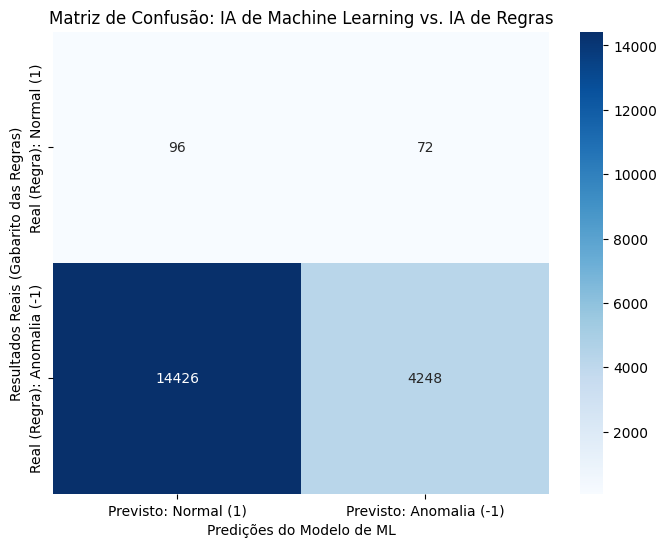


--- FIM DA VALIDAÇÃO ---


In [4]:
print("--- CÉLULA 4: MÉTRICAS FINAIS PARA O TCC ---")

# Calcular as Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=-1) # Foco em anomalias (-1)
recall = recall_score(y_test, y_pred, pos_label=-1) # Foco em anomalias (-1)
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])

print(f"\nACURÁCIA GERAL: {accuracy * 100:.2f}%")
print(f" (O modelo de ML e as Regras concordaram em {accuracy * 100:.2f}% dos casos no conjunto de teste)")

print(f"\nPRECISÃO (para Anomalias): {precision * 100:.2f}%")
print(f" (De todas as vezes que o ML detetou uma anomalia, {precision * 100:.2f}% delas também era uma anomalia para as Regras)")

print(f"\nRECALL (Sensibilidade para Anomalias): {recall * 100:.2f}%")
print(f" (De todas as anomalias detetadas pelas Regras, o ML conseguiu encontrar {recall * 100:.2f}% delas)")

print("\n--- MATRIZ DE CONFUSÃO ---")
# Criar um gráfico bonito para a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Previsto: Normal (1)', 'Previsto: Anomalia (-1)'], 
            yticklabels=['Real (Regra): Normal (1)', 'Real (Regra): Anomalia (-1)'])
plt.title('Matriz de Confusão: IA de Machine Learning vs. IA de Regras')
plt.ylabel('Resultados Reais (Gabarito das Regras)')
plt.xlabel('Predições do Modelo de ML')
plt.show()

print("\n--- FIM DA VALIDAÇÃO ---")